# Bayesian Optimization Python implementation

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scienceplots

plt.style.use('science')

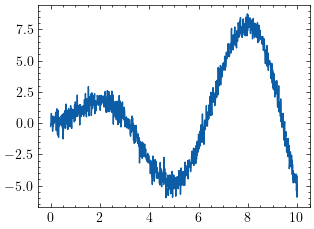

In [29]:
plt.plot(X_, f(X_))

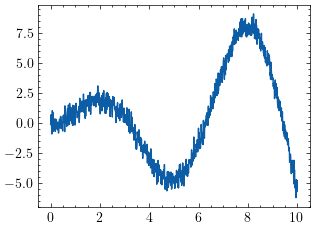

In [31]:
xs = np.linspace(0, 10, 1000)
plt.plot(xs, f(xs), label='f(x)')

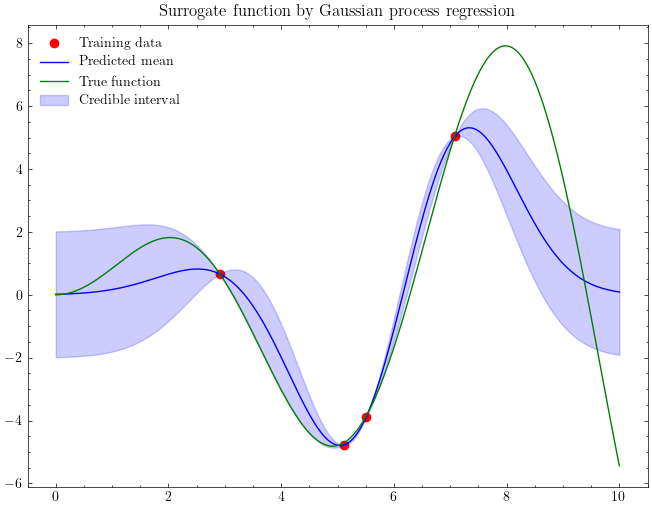

In [34]:
# Gaussian process regression example

np.random.seed(3)

## True function
def f(x):
    return x * np.sin(x)

## Training data
X = np.random.uniform(0, 10, 4)[:, np.newaxis]
y = f(X) + np.random.normal(0, 0.1, X.shape)

## Regression
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr.fit(X, y)

## Credible interval

X_ = np.linspace(0, 10, 1000)[:, np.newaxis]
y_mean, y_std = gpr.predict(X_, return_std=True)

## Plot
plt.figure(figsize=(8, 6))
plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_, y_mean, c='b', label='Predicted mean')
plt.plot(X_, f(X_), c='g', label='True function')
plt.fill_between(X_[:, 0], y_mean - 2*y_std, y_mean + 2*y_std, color='b', alpha=0.2, label='Credible interval')
plt.legend()
plt.title('Surrogate function by Gaussian process regression')
plt.show()

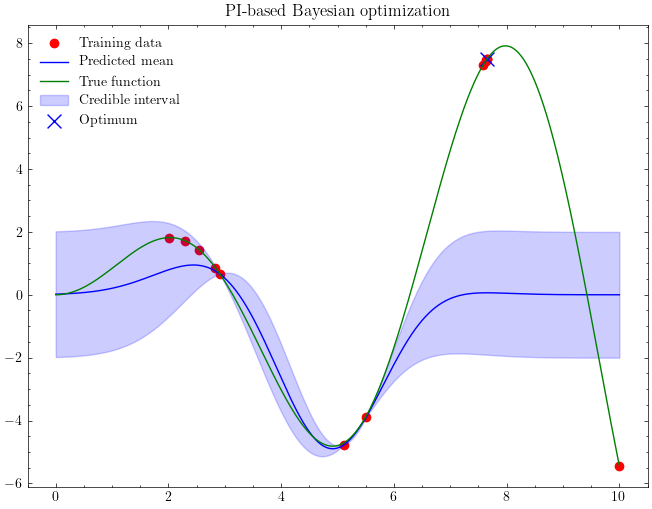

In [47]:
# Bayesian optimization with probability of improvement

from scipy.stats import norm

def probability_of_improvement(X, gpr, y_best, xi=0.01):
    y_mean, y_std = gpr.predict(X, return_std=True)
    Z = (y_mean - y_best - xi) / y_std
    return norm.cdf(Z)

## Bayesian optimization
np.random.seed(3)
X = np.random.uniform(0, 10, 4)[:, np.newaxis]
y = f(X) + np.random.normal(0, 0.1, X.shape)

X_opt = X[np.argmax(y)]
y_opt = np.max(y)

X = np.delete(X, np.argmax(y), axis=0)
y = np.delete(y, np.argmax(y), axis=0)

for i in range(10):
    gpr = GaussianProcessRegressor()
    gpr.fit(X, y)
    y_best = np.max(y)
    X_ = np.linspace(0, 10, 1000)[:, np.newaxis]
    y_poi = probability_of_improvement(X_, gpr, y_best)
    X_opt = X_[np.argmax(y_poi)]
    y_opt = f(X_opt)
    X = np.vstack([X, X_opt])
    y = np.append(y, y_opt)

## Plot
plt.figure(figsize=(8, 6))
plt.scatter(X, y, c='r', label='Training data')
plt.plot(X_, y_mean, c='b', label='Predicted mean')
plt.plot(X_, f(X_), c='g', label='True function')
plt.fill_between(X_[:, 0], y_mean - 2*y_std, y_mean + 2*y_std, color='b', alpha=0.2, label='Credible interval')
plt.scatter(X_opt, y_opt, c='b', marker='x', s=100, label='Optimum')
plt.legend()
plt.title('PI-based Bayesian optimization')
plt.show()

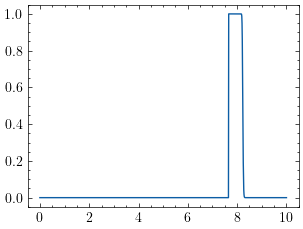

In [58]:
plt.plot(X_, y_poi)

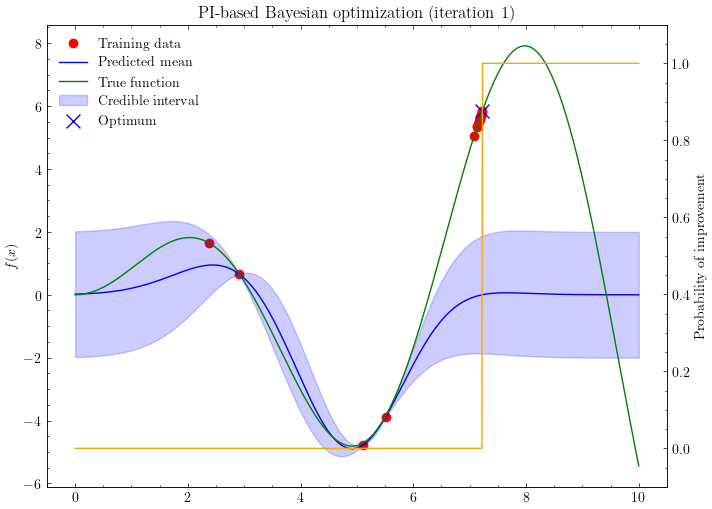

In [86]:
# Create an animated plot to png file
from matplotlib.animation import FuncAnimation

np.random.seed(3)
X = np.random.uniform(0, 10, 4)[:, np.newaxis]
y = f(X) + np.random.normal(0, 0.1, X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
ax.scatter(X, y, c='r', label='Training data')
ax.plot(X_, y_mean, c='b', label='Predicted mean')
ax.plot(X_, f(X_), c='g', label='True function')

def update(i):
    global X, y, X_opt, y_opt, ax2
    ax.cla()
    ax2.cla()
    gpr = GaussianProcessRegressor()
    gpr.fit(X, y)
    y_best = np.max(y)
    X_ = np.linspace(0, 10, 1000)[:, np.newaxis]
    y_poi = probability_of_improvement(X_, gpr, y_best)
    X_opt = X_[np.argmax(y_poi)]
    y_opt = f(X_opt)
    X = np.vstack([X, X_opt])
    y = np.append(y, y_opt)
    ax.scatter(X, y, c='r', label='Training data')
    ax.plot(X_, y_mean, c='b', label='Predicted mean')
    ax.plot(X_, f(X_), c='g', label='True function')
    ax.fill_between(X_[:, 0], y_mean - 2*y_std, y_mean + 2*y_std, color='b', alpha=0.2, label='Credible interval')
    ax.scatter(X_opt, y_opt, c='b', marker='x', s=100, label='Optimum')
    ax.legend()
    ax.set_ylabel('$f(x)$')
    ax2.set_ylim(-0.1, 1.1)
    ax2.plot(X_, y_poi, c='orange')
    ax2.set_ylabel('Probability of improvement')
    ax2.yaxis.set_label_position('right')
    ax.set_title(f'PI-based Bayesian optimization (iteration {i+1})')
    return ax

ani = FuncAnimation(fig, update, frames=10, interval=1000)
ani.save('bayesian_optimization.gif', writer='imagemagick')

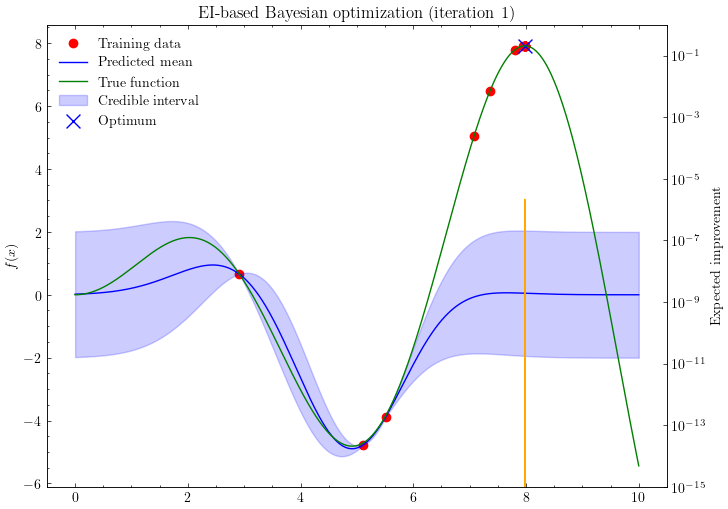

In [85]:
# Expected improvement

def expected_improvement(X, gpr, y_best, xi=0.01):
    # xi is a trade-off parameter between exploration and exploitation
    y_mean, y_std = gpr.predict(X, return_std=True)
    Z = (y_mean - y_best - xi) / y_std 
    return y_std * (Z * norm.cdf(Z) + norm.pdf(Z))

## Animated plot

np.random.seed(3)
X = np.random.uniform(0, 10, 4)[:, np.newaxis]
y = f(X) + np.random.normal(0, 0.1, X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
ax.scatter(X, y, c='r', label='Training data')
ax.plot(X_, y_mean, c='b', label='Predicted mean')
ax.plot(X_, f(X_), c='g', label='True function')

def update(i):
    global X, y, X_opt, y_opt, ax2
    ax.cla()
    ax2.cla()
    gpr = GaussianProcessRegressor()
    gpr.fit(X, y)
    y_best = np.max(y)
    X_ = np.linspace(0, 10, 1000)[:, np.newaxis]
    y_ei = expected_improvement(X_, gpr, y_best, xi=0.0)
    X_opt = X_[np.argmax(y_ei)]
    y_opt = f(X_opt)
    X = np.vstack([X, X_opt])
    y = np.append(y, y_opt)
    ax.scatter(X, y, c='r', label='Training data')
    ax.plot(X_, y_mean, c='b', label='Predicted mean')
    ax.plot(X_, f(X_), c='g', label='True function')
    ax.fill_between(X_[:, 0], y_mean - 2*y_std, y_mean + 2*y_std, color='b', alpha=0.2, label='Credible interval')
    ax.scatter(X_opt, y_opt, c='b', marker='x', s=100, label='Optimum')
    ax.legend()
    ax.set_ylabel('$f(x)$')
    ax2.plot(X_, y_ei, c='orange')
    ax2.set_ylabel('Expected improvement')
    ax2.yaxis.set_label_position('right')
    ax2.set_yscale('log')
    ax2.set_ylim(1e-15, 1)
    ax.set_title(f'EI-based Bayesian optimization (iteration {i+1})')
    return ax

ani = FuncAnimation(fig, update, frames=10, interval=1000)
ani.save('bayesian_optimization_ei.gif', writer='imagemagick')

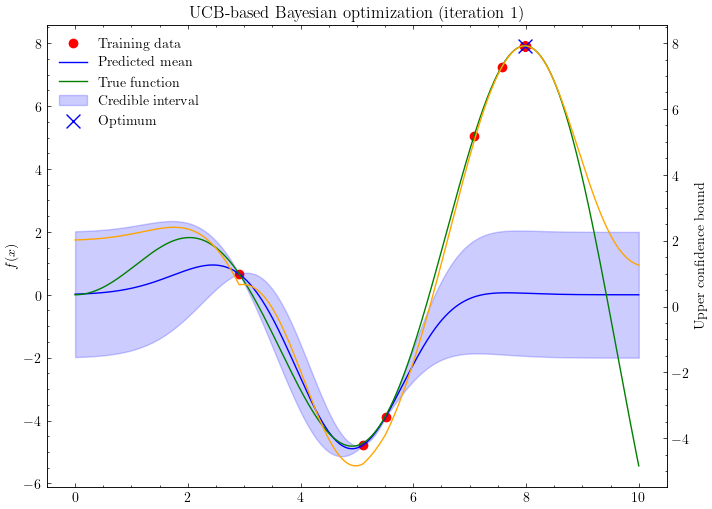

In [83]:
# Upper confidence bound

def upper_confidence_bound(X, gpr, kappa=1):
    y_mean, y_std = gpr.predict(X, return_std=True)
    return y_mean + kappa * y_std

## Animated plot

np.random.seed(3)
X = np.random.uniform(0, 10, 4)[:, np.newaxis]
y = f(X) + np.random.normal(0, 0.1, X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
ax.scatter(X, y, c='r', label='Training data')
ax.plot(X_, y_mean, c='b', label='Predicted mean')
ax.plot(X_, f(X_), c='g', label='True function')

def update(i):
    global X, y, X_opt, y_opt, ax2
    ax.cla()
    ax2.cla()
    gpr = GaussianProcessRegressor()
    gpr.fit(X, y)
    y_best = np.max(y)
    X_ = np.linspace(0, 10, 1000)[:, np.newaxis]
    y_ucb = upper_confidence_bound(X_, gpr, kappa=2)
    X_opt = X_[np.argmax(y_ucb)]
    y_opt = f(X_opt)
    X = np.vstack([X, X_opt])
    y = np.append(y, y_opt)
    ax.scatter(X, y, c='r', label='Training data')
    ax.plot(X_, y_mean, c='b', label='Predicted mean')
    ax.plot(X_, f(X_), c='g', label='True function')
    ax.fill_between(X_[:, 0], y_mean - 2*y_std, y_mean + 2*y_std, color='b', alpha=0.2, label='Credible interval')
    ax.scatter(X_opt, y_opt, c='b', marker='x', s=100, label='Optimum')
    ax.legend()
    ax.set_ylabel('$f(x)$')
    ax2.plot(X_, y_ucb, c='orange')
    ax2.set_ylabel('Upper confidence bound')
    ax2.yaxis.set_label_position('right')
    ax.set_title(f'UCB-based Bayesian optimization (iteration {i+1})')
    return ax

ani = FuncAnimation(fig, update, frames=10, interval=1000)
ani.save('bayesian_optimization_ucb.gif', writer='imagemagick')